# Final Capstone Notebook 4 out of 4 (Demo)

This is best viewed on google collab. Link [here.](https://colab.research.google.com/drive/1m9wZ4mi-ZrhShA8i1PtAoTCTritrekA9) This demo will demonstrate how the topic extractor can be used to analyze a restaurants performance.

In [69]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
gdrive = GoogleDrive(gauth)

# Code to load model from Google Drive:
import pickle
from google.colab import drive
drive.mount('/content/gdrive')

# Basic libraries
import numpy as np
import gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load 
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
sns.set(style="whitegrid")

# Supervised learning models
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import normalize

# Deep neutral networks
import tensorflow as tf

# Text manipulation tools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF
from wordcloud import WordCloud

# Remove column width so we can read entire text
pd.set_option('display.max_colwidth', 0)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load Dataset and Models

We will handle the dataset the same way that we handled it in notebook 2.

In [31]:
# Pull from Google Drive
downloaded = gdrive.CreateFile({'id':'1Dxm3PPE_pCSZ7FkKEScqk3JIvU25SOKO'})
downloaded.GetContentFile('comb_df.csv') 

# Read files as df
comb_df = pd.read_csv('comb_df.csv') 

comb_df.head(2)

,Unnamed: 0,business_id,lem_join,text,target,text_type,date,name
0,0,meXjqyhTNLFmknY39y2sMg,solid beer christmas ale define holiday season away long time ago home try stop great lakes great vibe super chill stellar food beer,"Solid beers -- Christmas Ale defines my holiday season. I moved away a long time ago, but whenever I am home, I try to make a stop at Great Lakes. Great vibe, super chill, stellar food and beer.",1.0,yelp_review,2014-09-11,"""Great Lakes Brewing Company"""
1,1,meXjqyhTNLFmknY39y2sMg,meh ok bartender night tell cleveland eat advice grab early dinner spend day rock n roll hall fame like alright 3 different server meal do not know never tell else care sudden else start come table server suggest pizza half decent not think suggest definitely not order not bad think hope well choice originally order beer flight 6 specialty beer do not like not not good beer sure not big beer drinker- no go husband drink order soda second server laugh nuff think experience like try new place especially local spot glad go not amazing time expect base tell fair maybe not normal- thing happen draw short straw not super impressed \n\n good gift shop sell specialty beer shop pack want plus nice merchandise choose,"Meh. It was OK. A bartender the night before somewhere told us that while we were in Cleveland we HAD to eat here, so we took her advice and grabbed an early dinner here after spending the day at the Rock N Roll Hall of Fame. Like I said, it was alright. We had 3 different servers through the meal (dont know what ANY of their names were, and was never told that someone else would be taking care of us... all the sudden, someone else just started coming to our table). The first server suggested the pizza because it was half off, so we both had one.. they were decent, but not something that I think I would have suggested to anyone, and definitely not something I would order again. Not that they were BAD, but I think (or I hope..) they have better choices. We originally ordered a beer flight of all 6 specialty beers, and I didn't like any of them (not because they weren't good beers, I'm sure they were, but for someone who isn't a big beer drinker- it was a no go), so my husband just drank all of them, and when I ordered a soda, our SECOND server laughed at me. 'Nuff said, I think. Anyway, it was an experience, and we both like trying new places, especially local spots, so I'm glad we went. It just wasn't the amazing time we were expecting based on what we had been told. And to be fair, maybe all of that isn't normal- sometimes things happen and you just draw the short straw. But we weren't super impressed.\n\nGood gift shop, though. They sell most of the specialty beers in the shop and you can make your own six packs of whatever you want. Plus they have some nice merchandise to choose from, too.",0.0,yelp_review,2013-10-13,"""Great Lakes Brewing Company"""


In [32]:
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66022 entries, 0 to 66021
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   66022 non-null  int64  
 1   business_id  66022 non-null  object 
 2   lem_join     66022 non-null  object 
 3   text         66022 non-null  object 
 4   target       66022 non-null  float64
 5   text_type    66022 non-null  object 
 6   date         66022 non-null  object 
 7   name         66022 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 4.0+ MB


# Set up NNMF vectorizer

In [0]:
# Linking words to topics
def word_topic(tfidf, solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic = tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    comp_df=pd.DataFrame(words_by_topic,index=wordlist)

    return comp_df

    # Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    
    list_df = []
    
    # Go through each component
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords = components.iloc[:,column].sort_values(ascending=False)
        
        # Choose the N highest loadings.
        chosen = sortedwords[:n_top_words].to_frame()
        
        # Format df
        chosen.rename(columns={column: 'Topic {}'.format(column)}, inplace=True)
        chosen = chosen.round(2) 
        
        # Add to list of dataframes
        list_df.append(chosen)

    return list_df

# Displays dataframes side by side for easy reading
def display_side_by_side(table_list):
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

In [0]:
# Split dataset
neg_text = comb_df[comb_df.target == 0]
pos_text = comb_df[comb_df.target == 1]

In [0]:
# Set up count vectorizer
addwords = ['like', 'tell', 'ok', 'come', 'good', 'do', 'no', 
            'not', 'never', 'nothing', 'none', 'go', 'else', 
            'elsewhere', 'well',
            ]

params = {'max_df': 0.5, 
          'min_df': 2, 
          'stop_words': addwords,
          'lowercase': True, 
          'ngram_range': (1,3)
          }

# Define vectorizers
bow_neg = CountVectorizer(**params)
bow_pos = CountVectorizer(**params)

# Transform negative reviews and get word list
neg_bow_list = bow_neg.fit_transform(neg_text.lem_join)
neg_bow_terms = bow_neg.get_feature_names()

# Transform positive reviews and get word list
pos_bow_list = bow_pos.fit_transform(pos_text.lem_join)
pos_bow_terms = bow_pos.get_feature_names()

In [0]:
# Set up NNMF
ntopics = 6

params = {'alpha': 0.0, 
          'init': 'nndsvdar',
          'l1_ratio': 0.0, 
          'max_iter': 200, 
          'n_components': ntopics, 
          'random_state': 0, 
          'solver': 'cd', 
          'tol': 0.0001, 
          'verbose': 0}

nmf_neg = NMF(**params)
nmf_pos = NMF(**params)

# Analyze negative reviews
X_nmf_neg = nmf_neg.fit_transform(neg_bow_list) 
comp_nmf_neg = word_topic(neg_bow_list, X_nmf_neg, neg_bow_terms)

# Analyze positive reviews
X_nmf_pos = nmf_pos.fit_transform(pos_bow_list) 
comp_nmf_pos = word_topic(pos_bow_list, X_nmf_pos, pos_bow_terms)

# Choose a restaurant

In [222]:
comb_df.business_id.value_counts()

GIfZNMP0oIJCje_Xp0Bgrw    1018
J1RDyyPxhioqm8c_fi4P4Q    978 
LNsZJP6jZ11e0tDljOLPiQ    911 
meXjqyhTNLFmknY39y2sMg    860 
_5PJ4GHIXNdUdXtohylKGQ    805 
                         ...  
OcXcAVjHoX0tTuzT5A8oww    3   
SkxDv7IpQWu8xvIPK92PuA    3   
8r9G0fUJpCFnbFWMdzzdMw    3   
WkzB0vF7A-a17N_5pfyGJg    3   
u-H6djIQKi73jNtFaoSuGA    3   
Name: business_id, Length: 1025, dtype: int64

In [0]:
# The Great Lakes Brewing Company
biz = 'meXjqyhTNLFmknY39y2sMg'

# Prepare Topic Extraction Plots

In [0]:
# Normalize for easy reading
X_neg_norm = pd.DataFrame(normalize(X_nmf_neg))
X_pos_norm = pd.DataFrame(normalize(X_nmf_pos))

# Combine weights and business info
df_neg = pd.concat([neg_text.reset_index(), pd.DataFrame(X_neg_norm)], axis=1)
df_pos = pd.concat([pos_text.reset_index(), pd.DataFrame(X_pos_norm)], axis=1)

# Average weights by business
df_agg_neg = df_neg.groupby(['business_id', 'name']).mean().reset_index()
df_agg_pos = df_pos.groupby(['business_id', 'name']).mean().reset_index()

In [0]:
# Make plot tables
col = range(0,6)

mask = (df_agg_neg.business_id == biz)
neg_table = df_agg_neg[mask][col].transpose().reset_index()

mask = (df_agg_pos.business_id == biz)
pos_table = df_agg_pos[mask][col].transpose().reset_index()

# Rename columns
new_names = {
    pos_table.columns[0]: 'Topic', 
    pos_table.columns[1]: 'Weight'
    }
pos_table.rename(columns=new_names, inplace=True)

new_names = {
    neg_table.columns[0]: 'Topic', 
    neg_table.columns[1]: 'Weight'
    }
neg_table.rename(columns=new_names, inplace=True)

# Name of restaurant
pos_table['type'] = df_agg_pos[df_agg_pos.business_id == biz].name.iloc[0]
neg_table['type'] = pos_table['type']

# Add average weights to tables
for n in col:
    neg_table.loc[len(pos_table)] = [n, df_neg[n].mean(), 'Area Average']
    pos_table.loc[len(pos_table)] = [n, df_pos[n].mean(), 'Area Average']

In [0]:
pos_topics = ['Chicken / Clean Restaurant', 
              'Great Service, Food, & Atmosphere', 
              'Loved by Locals', 'Fast Service', 
              'Great Bar Drinks & Music', 
              'Good Pizza']
neg_topics = ['Bad Bar Service', 
              'Bad Atmosphere', 
              'Wrong Orders', 
              'Bad Music', 
              'Slow Service', 
              'Bad Pizza']

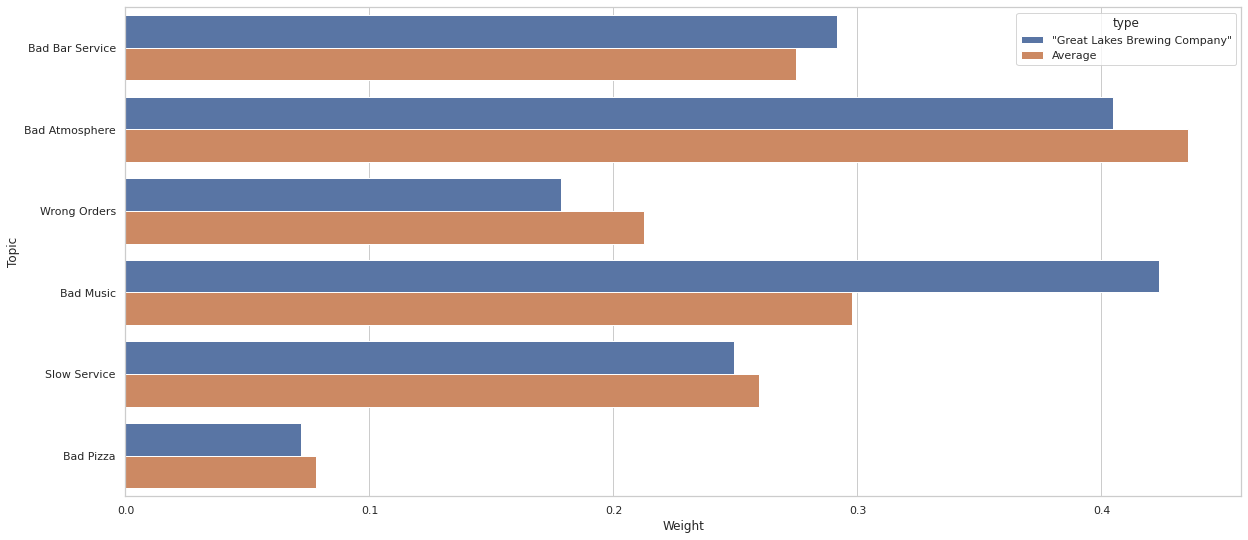

In [219]:
plt.figure(figsize=(20,9))
sns.barplot(x="Weight", y="Topic", hue='type', data=neg_table, orient='h')
plt.yticks(range(0,6), neg_topics)
plt.title("Negative Reviews"); 

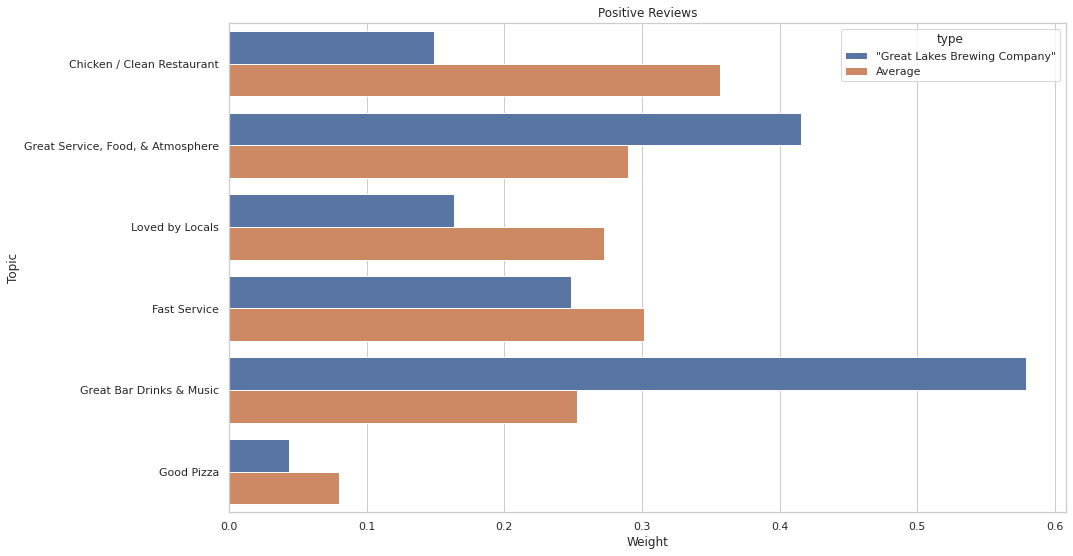

In [214]:
plt.figure(figsize=(15,9))
sns.barplot(x="Weight", y="Topic", hue='type', data=pos_table, orient='h')
plt.yticks(range(0,6), pos_topics)
plt.title("Positive Reviews"); 

We can see when looking at the Great Lakes Brewing Company that their bar scene is a major contribution to their success as well as the food and atmosphere. We can see that people have issues with their bar music. And even if they have great service, a lot of their negative reviews also come from bad service as well.

# Conclusion

In notebooks 2 and 3, I left conclusions for each phase of the project. In this notebook, I'd like to discuss how this project as a whole can be improved an expanded. The beauty of this project is it isn't limited to restaurants. We can train the sentiment classifier and topic extractor to work with other types of businesses as well. In addition, we could expand this project into more than one city. Because we only had Yelp tips to work with, we didn't get to see how the sentiment classifier with fare with unlabeled reviews from other media sources.
